In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import pickle
import scipy.sparse
from sklearn.model_selection import cross_validate, GridSearchCV, cross_val_predict
from sklearn.dummy import DummyClassifier
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import time

# Analyse Data

In [ ]:
meta_train = pd.read_csv("review_meta_train.csv")
meta_test = pd.read_csv("review_meta_test.csv")
text_train = pd.read_csv("review_text_train.csv")
text_test = pd.read_csv("review_text_test.csv")

In [ ]:
label_dst = meta_train.groupby('rating').count().reset_index().loc[:, ['rating', 'date']]
label_dst.columns = ['rating', 'distribution']
label_dst['distribution'] = round((label_dst['distribution']/sum(label_dst['distribution']))*100, 2)
label_dst

,rating,distribution
0,1,8.32
1,3,22.96
2,5,68.72


From the table above, it can be seen that most of the text got 5 star rating. 1 star rating is the least one and 3 star is in the middle. Thus, they don't have an equal distribution, and this may effect the training process. 

In [ ]:
print("Length of text training data:", len(text_train['review']))
print("Length of text test data: ", len(text_test['review']))

Length of text training data: 28068
Length of text test data:  7018


Extract data using CountVectorizer given

In [ ]:
count_vec_text_train = pickle.load(open("train_countvectorizer.pkl", "rb"))
vocab_text_train = count_vec_text_train.vocabulary_

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator CountVectorizer from version 0.21.3 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [ ]:
print("There are "+str(len(vocab_text_train))+" distinct words in the training set")

There are 41648 distinct words in the training set


Load the sparse matrix of the train text (becareful, the data might kill your RAM. Google Collab crash 2 times when load transform the object to an array)

Load the doc2vec dataset

In [ ]:
#train
doc2vec_text_train50 = pd.read_csv(r"review_text_train_doc2vec50.csv", index_col = False, delimiter = ',', header=None) 
doc2vec_text_train100 = pd.read_csv(r"review_text_train_doc2vec100.csv", index_col = False, delimiter = ',', header=None) 
doc2vec_text_train200 = pd.read_csv(r"review_text_train_doc2vec200.csv", index_col = False, delimiter = ',', header=None) 

#test
doc2vec_text_test50 = pd.read_csv(r"review_text_test_doc2vec50.csv", index_col = False, delimiter=',', header = None)
doc2vec_text_test100 = pd.read_csv(r"review_text_test_doc2vec100.csv", index_col = False, delimiter = ',', header=None) 
doc2vec_text_test200 = pd.read_csv(r"review_text_test_doc2vec200.csv", index_col = False, delimiter = ',', header=None) 


# adding the extra features for train data 
doc2vec_text_train50_extra = doc2vec_text_train50.copy()
doc2vec_text_train100_extra = doc2vec_text_train100.copy()
doc2vec_text_train200_extra = doc2vec_text_train200.copy()
frames = [doc2vec_text_train50_extra, meta_train.loc[:, ['vote_funny', "vote_cool", "vote_useful"]]]
frames_1 = [doc2vec_text_train100_extra, meta_train.loc[:, ['vote_funny', "vote_cool", "vote_useful"]]]
frames_2 = [doc2vec_text_train200_extra, meta_train.loc[:, ['vote_funny', "vote_cool", "vote_useful"]]]
doc2vec_text_train50_extra = pd.concat(frames, axis=1)
doc2vec_text_train100_extra = pd.concat(frames_1, axis=1)
doc2vec_text_train200_extra = pd.concat(frames_2, axis=1)

# adding the extra features for test data
doc2vec_text_test50_extra = doc2vec_text_test50.copy()
doc2vec_text_test100_extra = doc2vec_text_test100.copy()
doc2vec_text_test200_extra = doc2vec_text_test200.copy()
frames_test = [doc2vec_text_test50, meta_test.loc[:, ['vote_funny', "vote_cool", "vote_useful"]]]
frames_test1 = [doc2vec_text_test100, meta_test.loc[:, ['vote_funny', "vote_cool", "vote_useful"]]]
frames_test2 = [doc2vec_text_test200, meta_test.loc[:, ['vote_funny', "vote_cool", "vote_useful"]]]
doc2vec_text_test50_extra = pd.concat(frames_test, axis=1)
doc2vec_text_test100_extra = pd.concat(frames_test1, axis=1)
doc2vec_text_test200_extra = pd.concat(frames_test2, axis=1)

Get the original data count vec data

In [ ]:
X_train = scipy.sparse.load_npz('review_text_train_vec.npz')
y_train = meta_train['rating']
X_test = scipy.sparse.load_npz('review_text_test_vec.npz')

# get the additional features for the user vote, as this may help improve the classification accuracy
extra_features = meta_train.loc[:, ['vote_funny', "vote_cool", "vote_useful"]]
extra_features_test = meta_test.loc[:, ['vote_funny', "vote_cool", "vote_useful"]]
X_train_extra = scipy.sparse.hstack([X_train, extra_features]).tocsr()
X_test_extra = scipy.sparse.hstack([X_test, extra_features_test]).tocsr()

# Dimension Reduction

#Chi

In [ ]:
x2 = SelectKBest(chi2, k=50)
X_train_x2 = x2.fit_transform(X_train,y_train)
X_test_x2 = x2.transform(X_test)

Show the top 50 relevant words

In [ ]:
top_50_words_x2 = []
for feat_num in x2.get_support(indices=True):
    top_50_words_x2.append(count_vec_text_train.get_feature_names()[feat_num])

In [ ]:
X_train_x2_extra = scipy.sparse.hstack([X_train_x2, extra_features]).tocsr()
x_test_x2_extra = scipy.sparse.hstack([X_test_x2, extra_features_test]).tocsr()

# Mutual Information

In [ ]:
mi = SelectKBest(score_func=mutual_info_classif, k=50)
X_train_mi = mi.fit_transform(X_train,y_train)
X_test_mi = mi.transform(X_test)

In [ ]:
top_50_words_mui = []

for feat_num in mi.get_support(indices=True):
    top_50_words_mui.append(count_vec_text_train.get_feature_names()[feat_num])

In [ ]:
X_train_mi_extra = scipy.sparse.hstack([X_train_mi, extra_features]).tocsr()
x_test_mi_extra = scipy.sparse.hstack([X_test_mi, extra_features_test]).tocsr()

From the above 50 words, it can be seen that most of them are adj words, but some words like 'did didn wasn' are still included, and this may disturb the model valuation

In [ ]:
set(top_50_words_x2)-set(top_50_words_mui)

{'attitude', 'called', 'customers', 'hostess', 'poor', 'tasteless', 'waiter'}

In [ ]:
set(top_50_words_mui)-set(top_50_words_x2)

{'average', 'awesome', 'better', 'bit', 'fantastic', 'overpriced', 'think'}

It seems that from the top 50 words chosen, Chi manage to get more unique negative adj words in comparison to Mutual Information, and both have 7 different words

# Model

# Baseline ONE R

In [ ]:
data_train = [(doc2vec_text_train50, 'doc2vec50'), (X_train_x2, 'chi')]
for X, title in data_train:

  zero_r = DummyClassifier(strategy='most_frequent')
  scores = cross_validate(zero_r, X, y_train, cv=10, return_estimator=True)
  max_score = np.argmax(scores['test_score'])
  clf_max = scores['estimator'][max_score]
  benchmark_score = np.mean(scores['test_score'])
  print(title)
  print("Benchmark Score to beat: "+str(benchmark_score))
  print("Max score to beat: "+str(scores['test_score'][max_score]))

doc2vec50
Benchmark Score to beat: 0.6871882761277236
Max score to beat: 0.687455452601568
chi
Benchmark Score to beat: 0.6871882761277236
Max score to beat: 0.687455452601568


In [ ]:
#using any dataset will result in the same prediction
prediction_0 = clf_max.predict(X_test_extra)
instance_id = [i for i in range(1, len(prediction_0)+1)]
df = pd.DataFrame([])
df['Instance_id'] = instance_id
df['rating'] = list(prediction_0)
df.to_csv('test_zeroR_1.csv', index=False)

From using Zero R, we got 68.74% as the accuracy for all. Thus, this result will be used as the benchmark to test our various models

# Rating Model 1

The model that is used in this first model would be Multinomial Naive Bayes

In [ ]:
data_train = [(doc2vec_text_train50, 'doc2vec50'), (doc2vec_text_train50_extra, 'doc2vec50_extra'), (X_train_x2, 'chi'), (X_train_x2_extra, 'chi_extra'), (X_train_mi, 'mi'), (X_train_mi_extra, 'mi_extra'), (X_train, 'original'), (X_train_extra, 'original_extra')]
# set the class as multinomial NB
clf = MultinomialNB()

# set the list to store informations
clf_validate_max = []
avg_score = []
max_score_cv = []

# Multinomial can't have negative number; thus, doc2vec will be excluded

# iterate for every train data available using cross validation method
for X, title in data_train[2:]:
  scores = cross_validate(clf, X, y_train, cv=10, return_estimator=True)
  max_score = np.argmax(scores['test_score'])
  max_score_cv.append(scores['test_score'][max_score])
  clf_validate_max.append(scores['estimator'][max_score])
  avg_score.append(np.mean(scores['test_score']))
  print(title)
  print("avg accuracy: "+str(round((np.mean(scores['test_score'])*100), 2)))
  print("max accuracy: "+str(round((scores['test_score'][max_score])*100, 2)))

chi
avg accuracy: 78.04
max accuracy: 79.04
chi_extra
avg accuracy: 78.04
max accuracy: 78.94
mi
avg accuracy: 78.88
max accuracy: 79.84
mi_extra
avg accuracy: 78.73
max accuracy: 79.65
original
avg accuracy: 83.9
max accuracy: 84.72
original_extra
avg accuracy: 83.92
max accuracy: 84.57


Roughly, using cv of 10, it can be seen that original count vect data has the highest accuracy compared to the other; thus, to continue with the investigation, it is decided that count vector data with extra vote is used

### Hyperparameter tuning

In [ ]:
parameter_candidates = [
  {'alpha': [0.001, 0.01, 0.1, 1, 5, 10, 100]},
]

clf = GridSearchCV(estimator=MultinomialNB(), param_grid=parameter_candidates, n_jobs=-1)
clf.fit(X_train_extra, y_train)

print("Best accuracy: "+str(clf.best_score_))
print("Best alpha: "+str(clf.best_estimator_.alpha))


Best accuracy: 0.8384280321313741
Best alpha: 1


Since the best parameter is alpha=1, which is the default value, the investigation is over for MNB; thus, first model chosen to predict the rating is MNB with alpha=1, using the count vector data.

###Performance Analysis

In [ ]:
hold = [3, 4, 5, 6, 7, 8, 9, 10]
clf = MultinomialNB()
clf_validate_max = []
avg_score = []
max_score_cv = []
for each_hold in hold:
  scores = cross_validate(clf, X_train_extra, y_train, cv=each_hold, return_estimator=True)
  max_score = np.argmax(scores['test_score'])
  max_score_cv.append(scores['test_score'][max_score])
  clf_validate_max.append(scores['estimator'][max_score])
  avg_score.append(np.mean(scores['test_score']))
  print('MNB '+str(each_hold)+" cv")
  print("avg accuracy: "+str(round((np.mean(scores['test_score'])*100), 2)))
  print("max accuracy: "+str(round((scores['test_score'][max_score])*100, 2)))

MNB 3 cv
avg accuracy: 83.55
max accuracy: 83.65
MNB 4 cv
avg accuracy: 83.69
max accuracy: 83.88
MNB 5 cv
avg accuracy: 83.84
max accuracy: 84.25
MNB 6 cv
avg accuracy: 83.88
max accuracy: 84.31
MNB 7 cv
avg accuracy: 83.95
max accuracy: 85.08
MNB 8 cv
avg accuracy: 83.92
max accuracy: 84.75
MNB 9 cv
avg accuracy: 84.01
max accuracy: 84.58
MNB 10 cv
avg accuracy: 83.92
max accuracy: 84.57


Text(0.5, 0.98, 'Multinomial NB Average Accuracy')

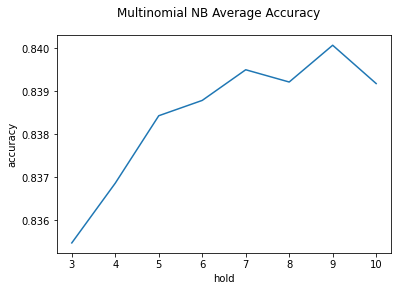

In [ ]:
plt.plot(hold,avg_score)
plt.xlabel('hold')
plt.ylabel('accuracy')
plt.suptitle('Multinomial NB Average Accuracy')

Calculate the predict proba using the fitted classifer for stack input

In [ ]:
MNB_max = clf_validate_max[6]
y_pred_mnb_proba = pd.DataFrame(MNB_max.predict_proba(X_test_extra))

Calculate the evaluation metrics: time and classification report

In [ ]:
start = time.time()
scores = cross_validate(clf, X_train_extra, y_train, cv=10, return_estimator=True)
end = time.time()
print("Total time: ", str(end-start))

Total time:  0.2959418296813965


In [ ]:
y_pred = cross_val_predict(clf, X_train_extra, y_train, cv=9)
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           1       0.74      0.60      0.66      2336
           3       0.69      0.64      0.67      6444
           5       0.89      0.94      0.91     19288

    accuracy                           0.84     28068
   macro avg       0.78      0.73      0.75     28068
weighted avg       0.83      0.84      0.84     28068



In [ ]:
print(confusion_matrix(y_train, y_pred))

[[ 1398   748   190]
 [  328  4143  1973]
 [  159  1091 18038]]


Turns out that without doing feature selection, MNB is very fast in learning all of the features, and it also increases its accuracy. Thus, it is decided that the final model would be to train the model using all of the features with MNB, and do a CV of 9 fold.

#### Prediction for the test

In [ ]:
prediction_1 = MNB_max.predict(X_test_extra)
instance_id = [i for i in range(1, len(prediction_1)+1)]
df = pd.DataFrame([])
df['Instance_id'] = instance_id
df['rating'] = list(prediction_1)
df.to_csv('test_MNB_8.csv', index=False)

# Rating Model 2

In [ ]:
clf = LogisticRegression()

# already test on the rest of the data, but cell got deleted. Here is the most essential data
data_train = [(doc2vec_text_train200, 'doc2vec200'), (doc2vec_text_train200_extra, 'doc2vec200_extra'),
              (X_train, 'original'), (X_train_extra, 'original_extra')]

# set the list to store informations
clf_validate_max = []
avg_score = []
max_score_cv = []

# iterate for every train data available using cross validation method
for X, title in data_train:
  scores = cross_validate(clf, X, y_train, cv=10, return_estimator=True)
  max_score = np.argmax(scores['test_score'])
  max_score_cv.append(scores['test_score'][max_score])
  clf_validate_max.append(scores['estimator'][max_score])
  avg_score.append(np.mean(scores['test_score']))
  print(title)
  print("avg accuracy: "+str(round((np.mean(scores['test_score'])*100), 2)))
  print("max accuracy: "+str(round((scores['test_score'][max_score])*100, 2)))

doc2vec50
avg accuracy: 81.69
max accuracy: 83.07
doc2vec50_extra
avg accuracy: 82.21
max accuracy: 83.68
doc2vec100
avg accuracy: 82.59
max accuracy: 83.5
doc2vec100_extra
avg accuracy: 83.02
max accuracy: 83.75


ValueError: ignored

In logistic regression, the count vector original with extra user votes works better than the doc2vec, but still decided to investigate both

##Hyperparameter Tuning

In [ ]:
parameter_candidates = [
  {'C': [1, 10, 100], 'max_iter':[100, 1000, 10000], 'dual':[True, False], 'solver':['saga', 'sag'], 'multi_class':['multinomial']},
]

clf = GridSearchCV(estimator=LogisticRegression(), param_grid=parameter_candidates, n_jobs=-1)
clf.fit(doc2vec_text_train200_extra, y_train)

print("Best accuracy: "+str(clf.best_score_))
print("Best C: "+str(clf.best_estimator_.C))
print("Best max_iter: "+str(clf.best_estimator_.max_iter))
print("Best dual: "+str(clf.best_estimator_.dual))
print("Best solver: "+str(clf.best_estimator_.solver))


/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Best accuracy: 0.8355065099969273
Best C: 10
Best max_iter: 100
Best dual: False
Best solver: saga


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


## Performance Analysis

Testing on the doc2vec data

In [ ]:
hold = [3, 4, 5, 6, 7, 8, 9, 10]
clf = LogisticRegression(C=10, max_iter=1000, solver='saga', multi_class='multinomial')
clf_validate_max = []
avg_score = []
max_score_cv = []
for each_hold in hold:
  scores = cross_validate(clf, doc2vec_text_train200_extra, y_train, cv=each_hold, return_estimator=True)
  max_score = np.argmax(scores['test_score'])
  max_score_cv.append(scores['test_score'][max_score])
  clf_validate_max.append(scores['estimator'][max_score])
  avg_score.append(np.mean(scores['test_score']))
  print('Logistic Regression '+str(each_hold)+" cv")
  print("avg accuracy: "+str(round((np.mean(scores['test_score'])*100), 2)))
  print("max accuracy: "+str(round((scores['test_score'][max_score])*100, 2)))

KeyboardInterrupt: ignored

In [ ]:
plt.plot(hold,avg_score)
plt.xlabel('fold')
plt.ylabel('accuracy')
plt.suptitle('Logistic Regression Average Accuracy')

Get the predict proba for stack input

In [ ]:
lr_2_max = score['estimator'][np.argmax(score['test_score'])]
y_pred_lr_2_proba = pd.DataFrame(lr_2_max.predict_proba(doc2vec_text_test200_extra))

In [ ]:
clf = LogisticRegression(C=10, max_iter=1000, solver='saga', multi_class='multinomial')
start = time.time()
y_pred = cross_val_predict(clf, doc2vec_text_train200_extra, y_train, cv=6)
end = time.time()
print(classification_report(y_train, y_pred))
print("Time:", str(end-start))
print(confusion_matrix(y_train, y_pred))

              precision    recall  f1-score   support

           1       0.73      0.60      0.66      2336
           3       0.72      0.61      0.66      6444
           5       0.88      0.94      0.91     19288

    accuracy                           0.84     28068
   macro avg       0.78      0.72      0.74     28068
weighted avg       0.83      0.84      0.83     28068

Time: 173.35380625724792
[[ 1394   537   405]
 [  380  3931  2133]
 [  135  1009 18144]]


Testing on the count vector with extra user vote

In [ ]:
hold = [3, 4, 5, 6, 7, 8, 9, 10]
clf = LogisticRegression(C=10, max_iter=2000, solver='saga', multi_class='multinomial')
clf_validate_max = []
avg_score = []
max_score_cv = []
for each_hold in hold:
  scores = cross_validate(clf, X_train_extra, y_train, cv=each_hold, return_estimator=True)
  max_score = np.argmax(scores['test_score'])
  max_score_cv.append(scores['test_score'][max_score])
  clf_validate_max.append(scores['estimator'][max_score])
  avg_score.append(np.mean(scores['test_score']))
  print('Logistic Regression '+str(each_hold)+" cv")
  print("avg accuracy: "+str(round((np.mean(scores['test_score'])*100), 2)))
  print("max accuracy: "+str(round((scores['test_score'][max_score])*100, 2)))

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Logistic Regression 3 cv
avg accuracy: 84.72
max accuracy: 85.06


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Logistic Regression 4 cv
avg accuracy: 85.01
max accuracy: 85.68


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the 

Logistic Regression 5 cv
avg accuracy: 84.98
max accuracy: 85.8


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the 

Logistic Regression 6 cv
avg accuracy: 85.1
max accuracy: 85.83


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the 

Logistic Regression 7 cv
avg accuracy: 85.22
max accuracy: 85.76


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the 

Logistic Regression 8 cv
avg accuracy: 85.23
max accuracy: 86.09


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the 

Logistic Regression 9 cv
avg accuracy: 85.09
max accuracy: 86.18


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the 

Logistic Regression 10 cv
avg accuracy: 85.25
max accuracy: 86.39


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [ ]:
clf = LogisticRegression(C=10, max_iter=2000, solver='saga', multi_class='multinomial')
start = time.time()
y_pred = cross_val_predict(clf, X_train_extra, y_train, cv=10)
end = time.time()
print(classification_report(y_train, y_pred))
print("Time:", str(end-start))
print(confusion_matrix(y_train, y_pred))

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the 

              precision    recall  f1-score   support

           1       0.78      0.70      0.74      2336
           3       0.73      0.65      0.69      6444
           5       0.90      0.94      0.92     19288

    accuracy                           0.85     28068
   macro avg       0.80      0.76      0.78     28068
weighted avg       0.85      0.85      0.85     28068

Time: 969.6266918182373
[[ 1640   490   206]
 [  365  4218  1861]
 [  110  1109 18069]]


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


From the logistic regression, it is decided to use the count vector with extra user vote to represent the fit classifier; however, since the doc2vec result has its own forte, it is decided that it will be included in the stack for extra backup

Get the predict proba for stack input

In [ ]:
lr_1_max = clf_validate_max[-1]
y_pred_lr_1_proba = pd.DataFrame(lr_1_max.predict_proba(X_test_extra))

In [ ]:
#clf = LogisticRegression(C=10, max_iter=1000, solver='saga', multi_class='multinomial')
#scores = cross_validate(clf, X_train_extra, y_train, cv=10, return_estimator=True)
prediction_3 = clf_validate_max[-1].predict(X_test_extra)
instance_id = [i for i in range(1, len(prediction_3)+1)]
df = pd.DataFrame([])
df['Instance_id'] = instance_id
df['rating'] = list(prediction_3)
df.to_csv('test_logistic_4.csv', index=False)

# Rating Model 3



### Implement Stack for MNB and Logistic Regression using DT as meta

Use predict proba for each train

In [ ]:
start = time.time()
# prediction from MNB
mnb = MultinomialNB(alpha=1)
y_pred_mnb = cross_val_predict(mnb, X_train_extra, y_train, cv=7, method='predict_proba')
y_pred_mnb = pd.DataFrame(y_pred_mnb)

# prediction from Logistic Regression
lr_1 = LogisticRegression(C=10, max_iter=2000, solver='saga', multi_class='multinomial')
y_pred_lr_1 = cross_val_predict(lr_1, X_train_extra, y_train, cv=10, method='predict_proba')
y_pred_lr_1 = pd.DataFrame(y_pred_lr_1)

# prediction from Logistic Regression
lr_2 = LogisticRegression(C=10, max_iter=1000, solver='saga', multi_class='multinomial')
y_pred_lr_2 = cross_val_predict(lr_2, doc2vec_text_train200_extra, y_train, cv=6, method='predict_proba')
y_pred_lr_2 = pd.DataFrame(y_pred_lr_2)

end = time.time()
print('time:', str(end-start))

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the 

time: 1206.2880592346191


Set the predict train proba to test the classifier acc

In [ ]:
meta_input = pd.DataFrame([])
model = [y_pred_mnb, y_pred_lr_1, y_pred_lr_2]
counter=0
for model_proba in model:
  for i in range(3):
    meta_input[counter] = model_proba[i]
    counter += 1

Do the stack train testing to get the best classifier using logistic regression as the meta classifier

In [ ]:
meta = LogisticRegression()
score = cross_validate(meta, meta_input, y_train, cv=10, return_estimator=True)
print(score['test_score'])
print(np.mean(score['test_score']))

[0.86034913 0.8717492  0.87887424 0.85749911 0.86854293 0.87495547
 0.87210545 0.86034913 0.87990021 0.87918746]
0.8703512321934193


In [ ]:
meta_max = score['estimator'][np.argmax(score['test_score'])]

In [ ]:
start = time.time()
y_meta = cross_val_predict(meta_max, meta_input, y_train, cv=10)
end = time.time()
print(classification_report(y_train, y_meta))
print('time: '+str(end-start))
print(confusion_matrix(y_train, y_meta))

              precision    recall  f1-score   support

           1       0.83      0.71      0.76      2336
           3       0.76      0.68      0.72      6444
           5       0.91      0.95      0.93     19288

    accuracy                           0.87     28068
   macro avg       0.83      0.78      0.80     28068
weighted avg       0.87      0.87      0.87     28068

time: 7.366491317749023
[[ 1654   511   171]
 [  283  4407  1754]
 [   61   859 18368]]


## Proba test

In [ ]:
meta_input_test = pd.DataFrame([])
model_test = [y_pred_mnb_proba, y_pred_lr_1_proba, y_pred_lr_2_proba]
counter=0

for model_proba in model_test:
  for i in range(3):
    meta_input_test[counter] = model_proba[i]
    counter += 1

In [ ]:
meta_prediction = meta_max.predict(meta_input_test)
df = pd.DataFrame([])
df['Instance_id'] = [i for i in range(1, len(meta_prediction)+1)]
df['rating'] = list(meta_prediction)
df.to_csv('test_stack_8.csv', index=False)